In [1]:
import sys
import cv2
import numpy as np
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

E0000 00:00:1739270029.555054      74 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230


In [2]:
NUM_BLOCKS = 9
block_size = int(27 / np.sqrt(NUM_BLOCKS))

In [3]:
def calculate_centroid(block):
    """Calculate the centroid of a 2D matrix"""
    rows, cols = block.shape
    x_centroid = 0.0
    y_centroid = 0.0
    for i in range(rows):
        for j in range(cols):
            x_centroid += i * block[i, j]
            y_centroid += j * block[i, j]
    total = np.sum(block)
    x_centroid = x_centroid / total
    y_centroid = y_centroid / total
    return x_centroid, y_centroid

In [4]:
def generate_chain_code(image):
    image = np.dstack([image, image, image])
    img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, img_bin = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
    row, col = img_bin.shape
    if np.all(img_bin == 0):
        img_bin[np.random.randint(0, row, 2), np.random.randint(0, col, 2)] = 255
    contours, _ = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    chain_code = []
    point = contours[0][0][0]
    for i in range(1, len(contours[0])):
        next_point = contours[0][i][0]
        diff = next_point - point
        if diff[0] == 0 and diff[1] == 1:
            chain_code.append(6)
        elif diff[0] == -1 and diff[1] == 1:
            chain_code.append(5)
        elif diff[0] == -1 and diff[1] == 0:
            chain_code.append(4)
        elif diff[0] == -1 and diff[1] == -1:
            chain_code.append(3)
        elif diff[0] == 0 and diff[1] == -1:
            chain_code.append(2)
        elif diff[0] == 1 and diff[1] == -1:
            chain_code.append(1)
        elif diff[0] == 1 and diff[1] == 0:
            chain_code.append(0)
        elif diff[0] == 1 and diff[1] == 1:
            chain_code.append(7)
        point = next_point
    return chain_code

In [5]:
def extract_features_with_chain_code(image):
    features = np.zeros((block_size, block_size, 50))
    for i in range(0, 27, block_size):
        for j in range(0, 27, block_size):
            block = image[i : i + block_size, j : j + block_size]
            chain_code = generate_chain_code(block)
            # print("chain len", len(chain_code))
            if len(chain_code) < 50:
                chain_code += [0] * (50 - len(chain_code))
            # print("chain", chain_code)
            features[i // block_size, j // block_size] = chain_code
    return features

In [6]:
def extract_features_with_centroid(image):
    features = np.zeros((block_size, block_size, 2))
    for i in range(0, 28, block_size):
        for j in range(0, 28, block_size):
            block = image[i : i + block_size, j : j + block_size]
            x_centroid, y_centroid = calculate_centroid(block)
            features[int(i / block_size), int(j / block_size), 0] = x_centroid
            features[int(i / block_size), int(j / block_size), 1] = y_centroid
    return features

In [7]:
def k_means(X, k=10, max_iters=sys.maxsize):
    centroids = X[np.random.choice(range(X.shape[0]), size=k, replace=False)]
    for _ in range(max_iters):
        labels = np.argmin(
            np.linalg.norm(X[:, np.newaxis] - centroids, axis=-1), axis=-1
        )
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    return centroids, labels

In [8]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

       0/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

   49152/11490434 ━━━━━━━━━━━━━━━━━━━━ 25s 2us/step

   81920/11490434 ━━━━━━━━━━━━━━━━━━━━ 28s 3us/step

  147456/11490434 ━━━━━━━━━━━━━━━━━━━━ 19s 2us/step

  212992/11490434 ━━━━━━━━━━━━━━━━━━━━ 16s 1us/step

  294912/11490434 ━━━━━━━━━━━━━━━━━━━━ 13s 1us/step

  442368/11490434 ━━━━━━━━━━━━━━━━━━━━ 10s 1us/step

  622592/11490434 ━━━━━━━━━━━━━━━━━━━━ 8s 1us/step 

  901120/11490434 ━━━━━━━━━━━━━━━━━━━━ 6s 1us/step

 1327104/11490434 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 1802240/11490434 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 3497984/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

 5292032/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

 7618560/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

10174464/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [9]:
x_train = x_train[:, 1:28, 1:28]
x_test = x_test[:, 1:28, 1:28]
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

In [10]:
encoder = OneHotEncoder()

In [11]:
x_train.shape, y_train.shape

((60000, 27, 27), (60000,))

In [12]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, shuffle=True
)

In [13]:
x_train.shape, y_train.shape

((48000, 27, 27), (48000,))

# Using Chain Code

In [14]:
train_features_with_chain_code = np.nan_to_num(
    np.array([extract_features_with_chain_code(image) for image in x_train])
)

In [15]:
train_features_with_chain_code.shape

(48000, 9, 9, 50)

In [16]:
train_features_with_chain_code = train_features_with_chain_code.reshape(
    train_features_with_chain_code.shape[0], -1
)

In [17]:
train_features_with_chain_code.shape

(48000, 4050)

In [18]:
centroids, labels = k_means(train_features_with_chain_code)

In [19]:
centroids.shape, labels.shape

((10, 4050), (48000,))

In [20]:
labels = encoder.fit_transform(labels.reshape(-1, 1)).toarray()
y_train = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()

In [21]:
accuracy_score(y_train, labels)

0.0583125

In [22]:
best = KMeans(n_clusters=10)
accuracies = np.array([])
max_acc = 0
for _ in range(10):
    kmeans = KMeans(n_clusters=10)
    kmeans.fit(train_features_with_chain_code)
    labels = kmeans.predict(train_features_with_chain_code)
    labels = encoder.fit_transform(labels.reshape(-1, 1)).toarray()
    acc = accuracy_score(y_train, labels)
    print("Accuracy: ", acc)
    accuracies = np.append(accuracies, acc)
    if max_acc < accuracies.max():
        max_acc = accuracies.max()
        best = kmeans
print("max acc: ", max_acc)

Accuracy:  0.07479166666666667


Accuracy:  0.0571875


Accuracy:  0.08841666666666667


Accuracy:  0.049541666666666664


Accuracy:  0.06829166666666667


Accuracy:  0.10914583333333333


Accuracy:  0.07329166666666667


Accuracy:  0.09983333333333333


Accuracy:  0.08797916666666666


Accuracy:  0.07033333333333333
max acc:  0.10914583333333333


In [23]:
y_train = np.argmax(y_train, axis=1)
labels = np.argmax(labels, axis=1)

In [24]:
y_train.shape, labels.shape

((48000,), (48000,))

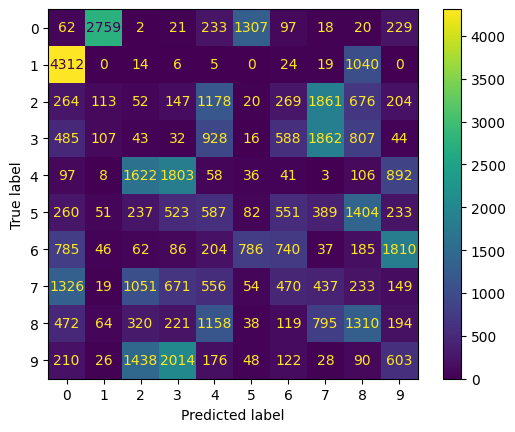

In [25]:
cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, labels))
cm.plot()
plt.show()

# Using Centroid

In [26]:
train_features_with_centroid = np.nan_to_num(
    np.array([extract_features_with_centroid(image) for image in x_train])
)

/tmp/ipykernel_74/13632873.py:8: RuntimeWarning: overflow encountered in scalar multiply
  x_centroid += i * block[i, j]
/tmp/ipykernel_74/13632873.py:9: RuntimeWarning: overflow encountered in scalar multiply
  y_centroid += j * block[i, j]
/tmp/ipykernel_74/13632873.py:11: RuntimeWarning: invalid value encountered in divide
  x_centroid = x_centroid / total
/tmp/ipykernel_74/13632873.py:12: RuntimeWarning: invalid value encountered in divide
  y_centroid = y_centroid / total
/tmp/ipykernel_74/13632873.py:11: RuntimeWarning: invalid value encountered in scalar divide
  x_centroid = x_centroid / total
/tmp/ipykernel_74/13632873.py:12: RuntimeWarning: invalid value encountered in scalar divide
  y_centroid = y_centroid / total


In [27]:
train_features_with_centroid.shape

(48000, 9, 9, 2)

In [28]:
train_features_with_centroid = train_features_with_centroid.reshape(
    train_features_with_centroid.shape[0], -1
)

In [29]:
train_features_with_centroid.shape

(48000, 162)

In [30]:
centroids, labels = k_means(train_features_with_centroid)

In [31]:
centroids.shape, labels.shape

((10, 162), (48000,))

In [32]:
labels = encoder.fit_transform(labels.reshape(-1, 1)).toarray()
y_train = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()

In [33]:
accuracy_score(y_train, labels)

0.10152083333333334

In [34]:
best = KMeans(n_clusters=10)
accuracies = np.array([])
max_acc = 0
for _ in range(10):
    kmeans = KMeans(n_clusters=10)
    kmeans.fit(train_features_with_centroid)
    labels = kmeans.predict(train_features_with_centroid)
    labels = encoder.fit_transform(labels.reshape(-1, 1)).toarray()
    acc = accuracy_score(y_train, labels)
    print("Accuracy: ", acc)
    accuracies = np.append(accuracies, acc)
    if max_acc < accuracies.max():
        max_acc = accuracies.max()
        best = kmeans
print("max acc: ", max_acc)

Accuracy:  0.1210625


Accuracy:  0.043083333333333335


Accuracy:  0.0574375


Accuracy:  0.06289583333333333


Accuracy:  0.04552083333333334


Accuracy:  0.11210416666666667


Accuracy:  0.09489583333333333


Accuracy:  0.0845


Accuracy:  0.08327083333333334


Accuracy:  0.09647916666666667
max acc:  0.1210625


In [35]:
y_train = np.argmax(y_train, axis=1)
labels = np.argmax(labels, axis=1)

In [36]:
y_train.shape, labels.shape

((48000,), (48000,))

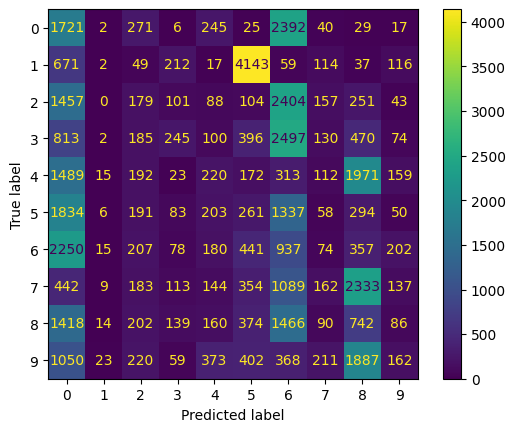

In [37]:
cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, labels))
cm.plot()
plt.show()